# Data Import

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import random

# Set the seed
random.seed(19)

In [54]:
ozone_betb011 = pd.read_csv("/content/drive/My Drive/DataThesis/ozone_betb011.csv")
ozone_betr012 = pd.read_csv("/content/drive/My Drive/DataThesis/ozone_betr012.csv")
ozone_betb004 = pd.read_csv("/content/drive/My Drive/DataThesis/ozone_betb004.csv")
ozone_betr001 = pd.read_csv("/content/drive/My Drive/DataThesis/ozone_betr001.csv")
ozone_betmeu1 = pd.read_csv("/content/drive/My Drive/DataThesis/ozone_betmeu1.csv")

In [4]:
ozone_betb011.set_index('DatetimeBegin', inplace=True)
ozone_betr012.set_index('DatetimeBegin', inplace=True)
ozone_betb004.set_index('DatetimeBegin', inplace=True)
ozone_betr001.set_index('DatetimeBegin', inplace=True)
ozone_betmeu1.set_index('DatetimeBegin', inplace=True)

In [55]:
betb011_ozone_ori = ozone_betb011.copy()
betr012_ozone_ori = ozone_betr012.copy()
betb004_ozone_ori = ozone_betb004.copy()
betr001_ozone_ori = ozone_betr001.copy()
betmeu1_ozone_ori = ozone_betmeu1.copy()

# **ARIMA INTER**

In [6]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit

import numpy as np

In [7]:
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)

# Betb011

In [8]:
ozone_betb011 = ozone_betb011.dropna(subset=['Concentration'])
betb011_ozone_ori = betb011_ozone_ori.dropna(subset=['Concentration'])

In [9]:
train_size = int(len(ozone_betb011) * 0.8)
train, test = ozone_betb011[:train_size], ozone_betb011[train_size:]

In [10]:
best_model = None
best_rmse = float('inf')

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            mse_values = []

            # Time Series Cross-Validation
            ts_cv = TimeSeriesSplit(n_splits=2)
            for train_index, val_index in ts_cv.split(train):
                train.index = pd.to_datetime(train.index)
                train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]

                if not train_fold.index.is_monotonic_increasing:
                  train_fold = train_fold.sort_index()

                # Fit ARIMA model
                model = SARIMAX(train_fold['Concentration'], order=order)
                fit_model = model.fit(disp=False)

                # Make predictions on the validation set
                predictions = fit_model.get_forecast(steps=len(val_fold))
                val_fold = val_fold.fillna(0)
                mse = mean_squared_error(val_fold, predictions.predicted_mean)
                mse_values.append(mse)

            # Calculate mean RMSE for the parameter combination
            avg_rmse = np.mean(np.sqrt(mse_values))

            # Update the best model if the current one is better
            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_model = order

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

In [11]:
print(best_model)

(3, 1, 1)


In [12]:
obj = 0.20
missing_values = int(len(ozone_betb011) * obj)
random_indices = np.random.choice(ozone_betb011.index, missing_values, replace=False)
ozone_betb011.loc[random_indices, 'Concentration'] = np.nan

In [13]:
train_data = ozone_betb011.loc[ozone_betb011['Concentration'].notna(), 'Concentration']
val_data = ozone_betb011.loc[ozone_betb011['Concentration'].isna(), 'Concentration']

train_data.index.freq = 'H'
if not train_data.index.is_monotonic_increasing:
    train_data = train_data.sort_index()

model = SARIMAX(train_data, order=best_model)
fit_model = model.fit(disp=False)

predictions = fit_model.get_forecast(steps=len(val_data))
test_data = betb011_ozone_ori.loc[random_indices, 'Concentration']
mse_b011 = mean_squared_error(test_data, predictions.predicted_mean)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [14]:
mse_b011

1033.8587739612751

# Betr012

In [15]:
ozone_betr012 = ozone_betr012.dropna(subset=['Concentration'])
betr012_ozone_ori = betr012_ozone_ori.dropna(subset=['Concentration'])

In [16]:
train_size = int(len(ozone_betr012) * 0.8)
train, test = ozone_betr012[:train_size], ozone_betr012[train_size:]

In [17]:
best_model = None
best_rmse = float('inf')

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            mse_values = []

            # Time Series Cross-Validation
            ts_cv = TimeSeriesSplit(n_splits=2)
            for train_index, val_index in ts_cv.split(train):
                train.index = pd.to_datetime(train.index)
                train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]

                if not train_fold.index.is_monotonic_increasing:
                  train_fold = train_fold.sort_index()

                # Fit ARIMA model
                model = SARIMAX(train_fold['Concentration'], order=order)
                fit_model = model.fit(disp=False)

                # Make predictions on the validation set
                predictions = fit_model.get_forecast(steps=len(val_fold))
                val_fold = val_fold.fillna(0)
                mse = mean_squared_error(val_fold, predictions.predicted_mean)
                mse_values.append(mse)

            # Calculate mean RMSE for the parameter combination
            avg_rmse = np.mean(np.sqrt(mse_values))

            # Update the best model if the current one is better
            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_model = order

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

In [18]:
print(best_model)

(1, 1, 0)


In [19]:
obj = 0.20
missing_values = int(len(ozone_betr012) * obj)
random_indices = np.random.choice(ozone_betr012.index, missing_values, replace=False)
ozone_betr012.loc[random_indices, 'Concentration'] = np.nan

In [20]:
train_data = ozone_betr012.loc[ozone_betr012['Concentration'].notna(), 'Concentration']
val_data = ozone_betr012.loc[ozone_betr012['Concentration'].isna(), 'Concentration']

train_data.index.freq = 'H'
if not train_data.index.is_monotonic_increasing:
    train_data = train_data.sort_index()
model = SARIMAX(train_data, order=best_model)
fit_model = model.fit(disp=False)

predictions = fit_model.get_forecast(steps=len(val_data))
test_data = betr012_ozone_ori.loc[random_indices, 'Concentration']
mse_r012 = mean_squared_error(test_data, predictions.predicted_mean)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [21]:
mse_r012

3174.5870006796113

# Betb004

In [22]:
ozone_betb004 = ozone_betb004.dropna(subset=['Concentration'])
betb004_ozone_ori = betb004_ozone_ori.dropna(subset=['Concentration'])

In [23]:
train_size = int(len(ozone_betb004) * 0.8)
train, test = ozone_betb004[:train_size], ozone_betb004[train_size:]

In [24]:
best_model = None
best_rmse = float('inf')

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            mse_values = []

            # Time Series Cross-Validation
            ts_cv = TimeSeriesSplit(n_splits=2)
            for train_index, val_index in ts_cv.split(train):
                train.index = pd.to_datetime(train.index)
                train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]

                if not train_fold.index.is_monotonic_increasing:
                  train_fold = train_fold.sort_index()

                # Fit ARIMA model
                model = SARIMAX(train_fold['Concentration'], order=order)
                fit_model = model.fit(disp=False)

                # Make predictions on the validation set
                predictions = fit_model.get_forecast(steps=len(val_fold))
                val_fold = val_fold.fillna(0)
                mse = mean_squared_error(val_fold, predictions.predicted_mean)
                mse_values.append(mse)

            # Calculate mean RMSE for the parameter combination
            avg_rmse = np.mean(np.sqrt(mse_values))

            # Update the best model if the current one is better
            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_model = order

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

In [25]:
print(best_model)

(2, 1, 1)


In [26]:
obj = 0.20
missing_values = int(len(ozone_betb004) * obj)
random_indices = np.random.choice(ozone_betb004.index, missing_values, replace=False)
ozone_betb004.loc[random_indices, 'Concentration'] = np.nan

In [27]:
train_data = ozone_betb004.loc[ozone_betb004['Concentration'].notna(), 'Concentration']
val_data = ozone_betb004.loc[ozone_betb004['Concentration'].isna(), 'Concentration']

train_data.index.freq = 'H'
if not train_data.index.is_monotonic_increasing:
    train_data = train_data.sort_index()
model = SARIMAX(train_data, order=best_model)
fit_model = model.fit(disp=False)

predictions = fit_model.get_forecast(steps=len(val_data))
test_data = betb004_ozone_ori.loc[random_indices, 'Concentration']
mse_b004 = mean_squared_error(test_data, predictions.predicted_mean)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python

In [28]:
mse_b004

681.8861102192756

# Betr001

In [29]:
ozone_betr001 = ozone_betr001.dropna(subset=['Concentration'])
betr001_ozone_ori = betr001_ozone_ori.dropna(subset=['Concentration'])

In [30]:
train_size = int(len(ozone_betr001) * 0.8)
train, test = ozone_betr001[:train_size], ozone_betr001[train_size:]

In [31]:
best_model = None
best_rmse = float('inf')

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            mse_values = []

            # Time Series Cross-Validation
            ts_cv = TimeSeriesSplit(n_splits=2)
            for train_index, val_index in ts_cv.split(train):
                train.index = pd.to_datetime(train.index)
                train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]

                if not train_fold.index.is_monotonic_increasing:
                  train_fold = train_fold.sort_index()

                # Fit ARIMA model
                model = SARIMAX(train_fold['Concentration'], order=order)
                fit_model = model.fit(disp=False)

                # Make predictions on the validation set
                predictions = fit_model.get_forecast(steps=len(val_fold))
                val_fold = val_fold.fillna(0)
                mse = mean_squared_error(val_fold, predictions.predicted_mean)
                mse_values.append(mse)

            # Calculate mean RMSE for the parameter combination
            avg_rmse = np.mean(np.sqrt(mse_values))

            # Update the best model if the current one is better
            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_model = order

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

In [32]:
print(best_model)

(0, 1, 0)


In [33]:
obj = 0.20
missing_values = int(len(ozone_betr001) * obj)
random_indices = np.random.choice(ozone_betr001.index, missing_values, replace=False)
ozone_betr001.loc[random_indices, 'Concentration'] = np.nan

In [34]:
train_data = ozone_betr001.loc[ozone_betr001['Concentration'].notna(), 'Concentration']
val_data = ozone_betr001.loc[ozone_betr001['Concentration'].isna(), 'Concentration']

train_data.index.freq = 'H'
if not train_data.index.is_monotonic_increasing:
    train_data = train_data.sort_index()
model = SARIMAX(train_data, order=best_model)
fit_model = model.fit(disp=False)

predictions = fit_model.get_forecast(steps=len(val_data))
test_data = betr001_ozone_ori.loc[random_indices, 'Concentration']
mse_r001 = mean_squared_error(test_data, predictions.predicted_mean)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [35]:
mse_r001

3065.0802251344085

# Betmeu1

In [56]:
ozone_betmeu1 = ozone_betmeu1.dropna(subset=['Concentration'])
betmeu1_ozone_ori = betmeu1_ozone_ori.dropna(subset=['Concentration'])

In [37]:
train_size = int(len(ozone_betmeu1) * 0.8)
train, test = ozone_betmeu1[:train_size], ozone_betmeu1[train_size:]

In [38]:
best_model = None
best_rmse = float('inf')

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            mse_values = []

            # Time Series Cross-Validation
            ts_cv = TimeSeriesSplit(n_splits=2)
            for train_index, val_index in ts_cv.split(train):
                train.index = pd.to_datetime(train.index)
                train_fold, val_fold = train.iloc[train_index], train.iloc[val_index]

                if not train_fold.index.is_monotonic_increasing:
                  train_fold = train_fold.sort_index()

                # Fit ARIMA model
                model = SARIMAX(train_fold['Concentration'], order=order)
                fit_model = model.fit(disp=False)

                # Make predictions on the validation set
                predictions = fit_model.get_forecast(steps=len(val_fold))
                val_fold = val_fold.fillna(0)
                mse = mean_squared_error(val_fold, predictions.predicted_mean)
                mse_values.append(mse)

            # Calculate mean RMSE for the parameter combination
            avg_rmse = np.mean(np.sqrt(mse_values))

            # Update the best model if the current one is better
            if avg_rmse < best_rmse:
                best_rmse = avg_rmse
                best_model = order

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/

In [39]:
print(best_model)

(1, 1, 3)


In [57]:
obj = 0.20
missing_values = int(len(ozone_betmeu1) * obj)
random_indices = np.random.choice(ozone_betmeu1.index, missing_values, replace=False)
ozone_betmeu1.loc[random_indices, 'Concentration'] = np.nan

In [58]:
train_data = ozone_betmeu1.loc[ozone_betmeu1['Concentration'].notna(), 'Concentration']
val_data = ozone_betmeu1.loc[ozone_betmeu1['Concentration'].isna(), 'Concentration']

train_data.index.freq = 'H'
if not train_data.index.is_monotonic_increasing:
    train_data = train_data.sort_index()
model = SARIMAX(train_data, order=best_model)
fit_model = model.fit(disp=False)

predictions = fit_model.get_forecast(steps=len(val_data))
test_data = betmeu1_ozone_ori.loc[random_indices, 'Concentration']
mse_meu1 = mean_squared_error(test_data, predictions.predicted_mean)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is av

In [59]:
mse_meu1

3504.902021571801

# **Evaluation between datasets**

In [62]:
import matplotlib.pyplot as plt

In [60]:
x_values = ['betb011','betr012','betb004','betr001','betmeu1']
y_values_lininter = [mse_b011,mse_r012,mse_b004,mse_r001,mse_meu1]

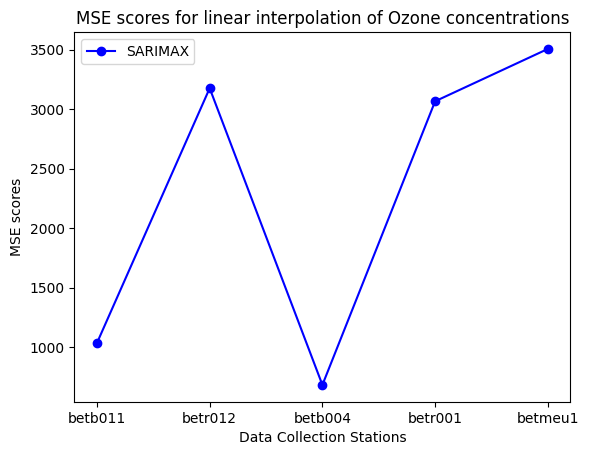

In [64]:
plt.plot(x_values, y_values_lininter, label='SARIMAX', marker='o', color='blue')
plt.xlabel('Data Collection Stations')
plt.ylabel('MSE scores')
plt.title('MSE scores for linear interpolation of Ozone concentrations')
plt.legend()
plt.show()